In [1]:
import numpy as np
from numpy import pi, cos, sin, tan
import matplotlib.pyplot as plt

In [2]:
h = 1 #The Planck constant
mass = 1 #The mass of the particle
sigma = 1 #The initial standard deviation
mu = -5 #The initial center
initial_momentum = 1 #The initial momentum

In [3]:
quantiles_count = 101 # The number of intial spatial grid points
dp0 = (1-0)/(quantiles_count-1)
P0 = np.linspace(0, 1, quantiles_count)
P0_shifted = pi*(P0 - 0.5)

# Here are two useful expressions
p0_cosines = cos(P0_shifted)
p0_sines = sin(P0_shifted)

time_steps = 1000 # The number of time steps
dt = 0.01 # The time increment

gamma = 1/3 # The Cauchy parameter
gamma_pi = gamma * pi

In [4]:
# Initialize the Cauchy quantiles positions and velocities
P = np.zeros([time_steps, quantiles_count])
V = np.zeros([time_steps, quantiles_count])

P[0, :] = P0
V[0, :] = initial_momentum/mass * (p0_cosines**2)/gamma_pi

# Utility method to exclude the boundary points from an array
def midpoints(Y):
    return Y[1:quantiles_count-1]

In [5]:
# Utility method to compute finite difference coefficients
def fin_diff_calc(stencil_size, order, shift):
    # s is the shift of the left end of the stencil from the approximation point
    M = np.zeros([stencil_size, stencil_size])
    for n in range(stencil_size):
        for k in range(stencil_size):
            if n == 0:
                M[n, k] = 1
            else:
                M[n, k] = (shift+k)**n
    right = np.zeros([stencil_size])
    right[order] = np.math.factorial(order)
    ans = np.matmul(np.linalg.inv(M), right)
    return ans

# Returns a finite diffrence matrix which can be used to derive vectors
def derivation_matrix(stencil_size, order, gp_count):
    wei = np.zeros([gp_count, gp_count])
    for i in range(gp_count):
        if i < stencil_size//2:
            wei[i, :stencil_size] = fin_diff_calc(stencil_size, order, -i)
        elif i >= gp_count - (stencil_size//2):
            wei[i, gp_count - stencil_size:] = fin_diff_calc(stencil_size, order, -stencil_size + gp_count-i)
        else:
            if stencil_size % 2 == 1:
                wei[i, i-(stencil_size//2): i+(stencil_size//2)+1] = fin_diff_calc(stencil_size, order, -(stencil_size//2))
            else:
                wei[i, i-(stencil_size//2) + 1: i+(stencil_size//2)] = fin_diff_calc(stencil_size, order, -(stencil_size//2))
    return wei

In [6]:
# Compute the derivation matrices
wei1 = derivation_matrix(15, 1, quantiles_count)
wei2 = derivation_matrix(15, 2, quantiles_count)
wei3 = derivation_matrix(15, 3, quantiles_count)

In [7]:
# Computes the first derivative of Y with respect to x0
def derive1(Y):
    return np.matmul(wei1, Y)/dp0

# Computes the second derivative of Y with respect to x0
def derive2(Y):
    return np.matmul(wei2, Y)/(dp0**2)

# Computes the third derivative of Y with respect to x0
def derive3(Y):
    return np.matmul(wei3, Y)/(dp0**3)

In [8]:
def xderive1(Y):
    return (1/(gamma_pi))*(p0_cosines**2) * derive1(Y)

def xderive2(Y):
    return (1/(gamma_pi)**2)*(p0_cosines**4) * derive2(Y) - (2/(gamma_pi**2))*(p0_cosines**3)*p0_sines*(derive1(Y))

def xderive3(Y):
    term1 = 1/(gamma_pi**3) * (p0_cosines**6) * derive3(Y)
    term2 = -6/(gamma * gamma_pi**2) *(p0_cosines**5)*p0_sines * (derive2(Y))
    term3 = 1/(gamma**2 * gamma_pi) * 6*(p0_sines**2)*(p0_cosines**4) - 2*(p0_cosines**6) * (derive1(Y))
    return term1 + term2 + term3

In [9]:
test_derive = False
if test_derive:
    # Test derive1
    print("Derive1:\n "+ str(abs(derive1(P0**2) - 2*P0))+"\n")

    # Test derive2
    print("Derive2:\n "+ str(abs(derive2(P0**2) - 2))+"\n")

    # Test derive3
    print("Derive3:\n "+ str(abs(derive3(P0**2) - 0)))

In [10]:
# Evaluate the initial X position of the distribution
# The boundary points are at infinity, so they are omitted
x0 = gamma*tan(P0_shifted[1:quantiles_count-1])

# A is R0'/R0
ratio1 = -0.5*(x0-mu)/(sigma**2)

# Compute the initial quantum potential -R0''/R0
qp0 = (2*sigma**2 - (x0-mu)**2)/(4*sigma**4)

# Compute the initial quantum force (R0''/R0)' = -Q0'
qf0 = (x0-mu)/(2*sigma**4)

In [11]:
# And now the dynamics
for i in range(time_steps-1):
    shifted_P = pi*(P[i] - 0.5)
    shifted_P_mid = midpoints(shifted_P)
    
    # Eta = 1/x'. The boundaries are set to 1.
    eta = np.ones((quantiles_count)) #This is 1/x'
    eta[1:quantiles_count-1] = midpoints( (cos(shifted_P))**2/(gamma_pi*xderive1(shifted_P)) )
    
    eta_mid = midpoints(eta)
    eta1 = midpoints(xderive1(eta))
    eta2 = midpoints(xderive2(eta))
    eta3 = midpoints(xderive3(eta))
    
    # The main step: computing the quantile acceleration
    # Because of the length of the formula, it is split into multiple lines
    # Boundary points are excluded from the computation
    QA1 = -2*pi*tan(shifted_P_mid)*(midpoints(V[i])**2)
    QA2 = qf0 * (eta_mid**3)
    QA3 = (-4*qp0 - 2*ratio1**2) * eta1 * (eta_mid**2)
    QA4 = 2 * ratio1 * (eta_mid * (eta1)**2 + (eta_mid**2) * eta2)
    QA5 = (eta_mid * eta1 * eta2)
    QA6 = 0.5 * (eta_mid**2) * eta3
    
    # Putting it all together
    # The boundary values are set to zero
    acc = np.zeros((quantiles_count))
    acc[1:quantiles_count-1] = QA1 + ((h/mass)**2 / (2*gamma_pi)) * (cos(shifted_P_mid)**2) * (QA1 + QA2 + QA3 + QA4 + QA5 + QA6)
    
    # Updating the quantile velocities and positions
    V[i+1] = V[i] + acc*dt    
    P[i+1] = P[i] + V[i]*dt + 0.5*acc*(dt**2)

C:\Users\Totom3\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in square
C:\Users\Totom3\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in cos
  
C:\Users\Totom3\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in tan
C:\Users\Totom3\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in cos


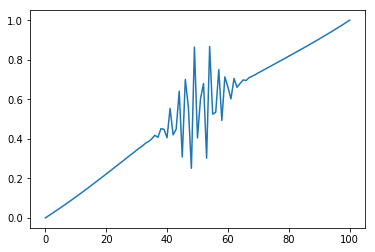

In [15]:
plt.plot(P[6])
plt.show()